In [1]:
import os
import numpy
from matplotlib import pyplot as plt

# initialize global variables here
epsilon = 1.67e-21         # energy parameter
sigma = 3.4e-10            # length parameter
cutoff = 3.5*sigma         # interaction cutoff

In [2]:
def getRelaxedLatticeConstant():
    '''
    function to calculate the relaxed lattice constant
    Input: None
    Output: None
    '''
    
    # initialize an array of lattice constants to be evaluated
    alat = [(5.0 + x/10) for x in range(10)]
    alat = 1e-10*numpy.array(alat) # get in Angstrom
    
    # to store energies corresponding to alats
    energies = []
    
    # loop over all lattice constants and calculate energy
    for a in alat:
        energies.append(getPotentialEnergy(a))
    
    
    # plot the graph
    plt.plot(alat * 1e+10, energies, 'ro-')
    plt.xlabel('Lattice Constant (A)')
    plt.ylabel('Energy (J)')
    plt.show()
    
    
    # simply find the minimum energy and return the corresponding lattice constant
    return alat[numpy.argmin(energies)]    

In [3]:
def getPotentialEnergy(alat):
    '''
    function to calculate the potential energy given the lattice constant
    Input: lattice constant
    Output: corresponding potential energy
    '''
    
    # generate unitcell corresponding to the given unitcell
    ucell = getUnitcell(alat)
    
    # generate supercell with all interactions corresponing to the given unitcell
    scell = getSupercell(ucell)
    
    # calculate energy corresponding to given unitcell and supercell
    return getEnergy(ucell, scell)

In [4]:
def getUnitcell(alat):
    '''
    function to generate unitcell given the lattice constant
    Input: lattice constant
    Output: dictionary consisting of lattice vectors and basis
    '''
    
    # lattice vectors
    lat_vec = [[alat, 0.0, 0.0], 
               [0.0, alat, 0.0], 
               [0.0, 0.0, alat]]
    lat_vec = numpy.array(lat_vec)
    
    # direct coordinates
    direct = [[0.0,0.0,0.0],
             [0.0,0.5,0.5],
             [0.5,0.0,0.5],
             [0.5,0.5,0.0]]
    direct = numpy.array(direct)
    
    # cart coordinates
    cart = numpy.matmul(direct, lat_vec)
    
    # collect all information into a dict object
    out = {'alat' : lat_vec, 
           'direct' : direct,
           'cart' : cart}
    
    return out

In [5]:
def getSupercell(ucell):
    '''
    function to generate Supercell including all interactions of the unitcell atoms
    Input: unitcell
    Output: dictionary consisting of lattice vectors and basis of supercell
    '''
    
    '''
    here we need to repeat the ucell in x,y,z directions until we include all interactions.
    However, we do not know 'how many times to repeat' beforehand.
    As such, we need to iterate here.
    '''

    '''
    We will start will some initial number of rep, Nrep=[1,1,1] in x,y,z directions.
    For this Nrep, we will count the number of neighbors of unitcell atoms within the cutoff cloud.
    Next, we will increase Nrep by one and check if the number of neighbors change.
    if neighbors_count do not change on increasing Nrep, then supercell is of right size.
    else we need to increas ethe size.
    '''

    Nrep = 1

    # we will exit inside the loop
    while True:
        
        # get supercell of Nrep size and count neighbors
        scell = getRepeatedCell(ucell, Nrep)
        neighbor_current = countNeighbors(ucell, scell)
        
        # get supercell of Nrep+1 size and count neighbors
        scell = getRepeatedCell(ucell, Nrep+1)
        neighbor_next = countNeighbors(ucell, scell)
        
        # if neighbors count is same, then cell is already big enough and we exit
        if neighbor_current == neighbor_next:
            break
        
        # increase the Nrep size as cell was not big enough.
        Nrep += 1
        
    # at this point we have the required Nrep value. We will simple generate scell and return.
    return getRepeatedCell(ucell, Nrep)
    

In [6]:
def getRepeatedCell(ucell, Nrep):
    '''
    function to generate a supercell of given size
    Input: unitcell and Number of repetitions
    Output: supercell
    '''
    
    # loop over x y and z
    direct = []
    for i in range(-Nrep, Nrep+1):
        for j in range(-Nrep, Nrep+1):
            for k in range(-Nrep, Nrep+1):
                
                # loop over atoms in the unitcell
                for uatom in ucell['direct']:
                    
                    # position in supercell is [pos_atom_inside_unitcell + pos_unitcell]
                    pos = uatom + [i,j,k]
                    direct.append(pos)
                        
    # get cartesian coordinates
    cart = numpy.matmul(direct, ucell['alat'])
    
    # get lattice vectors of supercell
    alat = (2*Nrep+1) * ucell['alat']
    
    # pack all informaton in a dictionary
    scell = {'cart': cart,
             'direct' : direct,
             'alat' : alat}
                        
    return scell    

In [7]:
def countNeighbors(ucell, scell):
    '''
    function to count the number of neighbors between atoms in unitcell and supercell
    Input: unitcell and supercell
    Output: number of neighbors
    '''
    
    # initialize the counter
    count = 0
    
    # loop over atoms in unitcell and supercell
    for uatom in ucell['cart']:
        for satom in scell['cart']:
            
            # get distance between atoms
            dist2 = numpy.sum((uatom - satom)**2)
            dist = numpy.sqrt(dist2)
            
            # check if distance is within cutoff
            if dist < (cutoff + 1e-15):
                count += 1
            
    # return the final counts        
    return count

In [8]:
def getEnergy(ucell, scell):
    '''
    function to calculate energy/atom of given ucell-scell
    Input: unitcell and supercell
    Output: Correspodning energy of system
    '''
    
    # initialize energy to zero
    energy = 0.0
    
    # loop over all unitcell atoms
    for uatom in ucell['cart']:
        
        # loop over all supercell atoms
        for satom in scell['cart']:
            
            # calculate distance
            dist2 = numpy.sum((uatom - satom)**2)
            dist = numpy.sqrt(dist2)
            
            # make sure that they are not the same atoms
            if dist < 1e-15:
                continue
            
            #-----------check if atom is in the unitcell
            factor = 1.0
            if atomInUnitcell(ucell, satom):
                factor = 0.5
            #-------------------------------------
            
            # add energy contribution
            energy += factor*4*epsilon*((sigma/dist)**12 - (sigma/dist)**6)
    
    
    '''
    Note that we have made one mistake here. In calculating energy, we looped over
    all atoms in the unitcell and all atoms in the supercell. As such, some pairs are double-counted.
    for instance, take an atom i in the ucell and atom j in the supercell, such that j is also in the unitcell.
    In this case, we will include E_ij. But when we loop over unitcell atoms and find j, we will include E_ji.
    We need to fix this and this will be a part of your HW assignment.
    '''
    
    # we need to get energy per atom -> divide by num atoms in unitcell
    return energy/len(ucell['cart'])

In [9]:
def atomInUnitcell(ucell, satom):
    '''
    function to check if given atom is in unitcell
    Input: unitcell and atom to check
    Output: boolean specifying if atom is in cell
    '''
    
    # loop over all unitcell atoms
    for uatom in ucell['cart']:
        # calculate distance
        dist2 = numpy.sum((uatom - satom)**2)
        dist = numpy.sqrt(dist2)
        
        if dist < 1e-6:
            return True
      
    return False

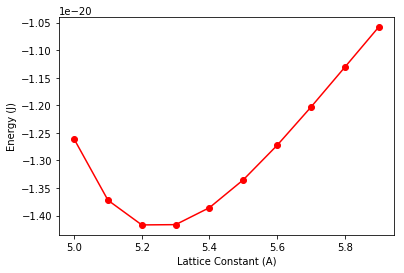

5.200000000000001e-10

In [10]:
getRelaxedLatticeConstant()
